# R - Portfolio Optimization

In [15]:
library(tidyquant)
library(ggplot2)
library(dplyr) #run if R doesn´t support group_by()
library(tseries)


Attaching package: 'dplyr'


The following objects are masked from 'package:xts':

    first, last


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [16]:
#tseries data for optimization
ibm = get.hist.quote(instrument = "ibm", start = "2000-01-01", end = "2019-10-01", quote = "Close")
wfc = get.hist.quote(instrument = "wfc", start = "2000-01-01", end = "2019-10-01", quote = "Close")
msft = get.hist.quote(instrument = "msft", start = "2000-01-01", end = "2019-10-01", quote = "Close")

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




time series starts 2000-01-03
time series ends   2019-09-30
time series starts 2000-01-03
time series ends   2019-09-30
time series starts 2000-01-03
time series ends   2019-09-30


In [17]:
#Getting returns by diff() method.
ribm = diff(log(ibm))
rwfc = diff(log(wfc))
rmsft = diff(log(msft))

returns = cbind(ribm, rwfc, rmsft)
rerurns = na.remove(returns)

matriz.covarianzas = cov(returns)

In [18]:
#Portfolio weight = pw
portafolio1 = portfolio.optim(returns, covmat = matriz.covarianzas)
portafolio1$pw

[1] 0.3237411 0.2539698 0.4222890

In [19]:
#Monthly returns: IBM, Wells Fargo, Microsoft
stock_returns_monthly <- c("IBM", "WFC", "MSFT") %>%
  tq_get(get  = "stock.prices",
         from = "2010-01-01",
         to   = "2019-10-01") %>%
  group_by(symbol) %>%
  tq_transmute(select     = adjusted, 
               mutate_fun = periodReturn, 
               period     = "monthly", 
               col_rename = "Ra")

In [20]:
#(Tech) Market returns
baseline_returns_monthly <- "XLK" %>%
  tq_get(get  = "stock.prices",
         from = "2010-01-01",
         to   = "2019-10-01") %>%
  tq_transmute(select     = adjusted, 
               mutate_fun = periodReturn, 
               period     = "monthly", 
               col_rename = "Rb")

In [21]:
#Sequential index n = 3
stock_returns_monthly_multi <- stock_returns_monthly %>%
  tq_repeat_df(n = 3)

Ungrouping data frame groups: symbol



In [22]:
#Weights
weights <- c(
  0.3237408, 0.2539673, 0.4222919, #Optimal
  0.25, 0.50, 0.25,
  0.25, 0.25, 0.50
)
stocks <- c("IBM", "WFC", "MSFT")
weights_table <-  tibble(stocks) %>%
  tq_repeat_df(n = 3) %>%
  bind_cols(tibble(weights)) %>%
  group_by(portfolio)

#Expand for portfolio
portfolio_returns_monthly_multi <- stock_returns_monthly_multi %>%
  tq_portfolio(assets_col  = symbol, 
               returns_col = Ra, 
               weights     = weights_table, 
               col_rename  = "Ra")

#Merge porfolio and Market
RaRb_multiple_portfolio <- left_join(portfolio_returns_monthly_multi, 
                                     baseline_returns_monthly,
                                     by = "date")


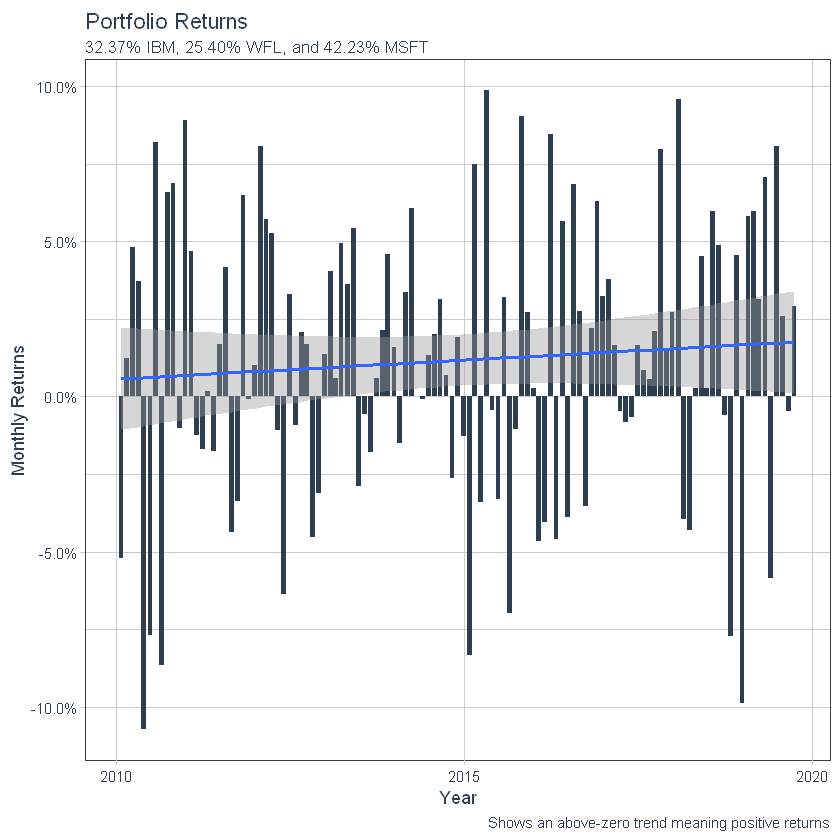

In [23]:
#PLOT

#Optimal
wts <- c(0.3237408, 0.2539673, 0.4222919) 

#Portfolio Returns
portfolio_returns_monthly <- stock_returns_monthly %>%
    tq_portfolio(assets_col  = symbol, 
                 returns_col = Ra, 
                 weights     = wts, 
                 col_rename  = "Ra")


portfolio_returns_monthly %>%
    ggplot(aes(x = date, y = Ra)) +
    geom_bar(stat = "identity", fill = palette_light()[[1]]) +
    labs(title = "Portfolio Returns",
         subtitle = "32.37% IBM, 25.40% WFL, and 42.23% MSFT",
         caption = "Shows an above-zero trend meaning positive returns",
         x = "Year", y = "Monthly Returns") +
    geom_smooth(method = "lm") +
    theme_tq() +
    scale_color_tq() +
    scale_y_continuous(labels = scales::percent) 

date,investment.growth
<date>,<dbl>
2019-04-30,325933.7
2019-05-31,306826.1
2019-06-28,331572.0
2019-07-31,340209.4
2019-08-30,338558.9
2019-09-30,348469.8


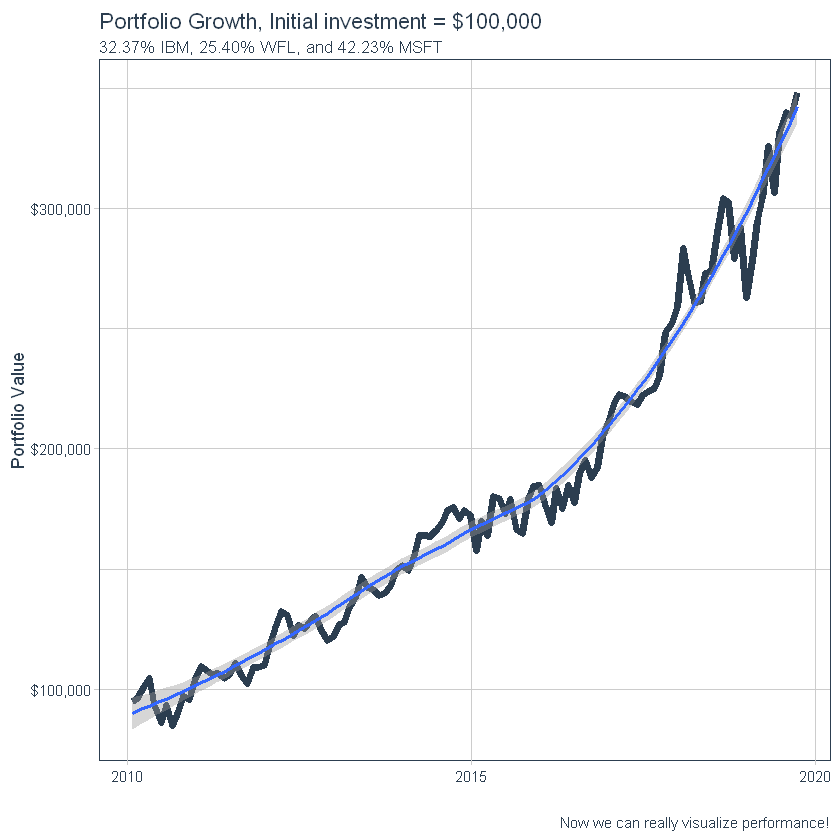

In [24]:
#Portafolio growth, initial investmente --> PV = $100,000
pv = 100000
portfolio_growth_monthly <- stock_returns_monthly %>%
    tq_portfolio(assets_col   = symbol, 
                 returns_col  = Ra, 
                 weights      = wts, 
                 col_rename   = "investment.growth",
                 wealth.index = TRUE) %>%
    mutate(investment.growth = investment.growth * pv)


portfolio_growth_monthly %>%
    ggplot(aes(x = date, y = investment.growth)) +
    geom_line(size = 2, color = palette_light()[[1]]) +
    labs(title = "Portfolio Growth, Initial investment = $100,000",
         subtitle = "32.37% IBM, 25.40% WFL, and 42.23% MSFT",
         caption = "Now we can really visualize performance!",
         x = "", y = "Portfolio Value") +
    geom_smooth(method = "loess") +
    theme_tq() +
    scale_color_tq() +
    scale_y_continuous(labels = scales::dollar)
tail(portfolio_growth_monthly)

portfolio,date,investment.growth
<int>,<date>,<dbl>
3,2019-04-30,355982.1
3,2019-05-31,335764.5
3,2019-06-28,362902.9
3,2019-07-31,371484.3
3,2019-08-30,371332.6
3,2019-09-30,380800.1


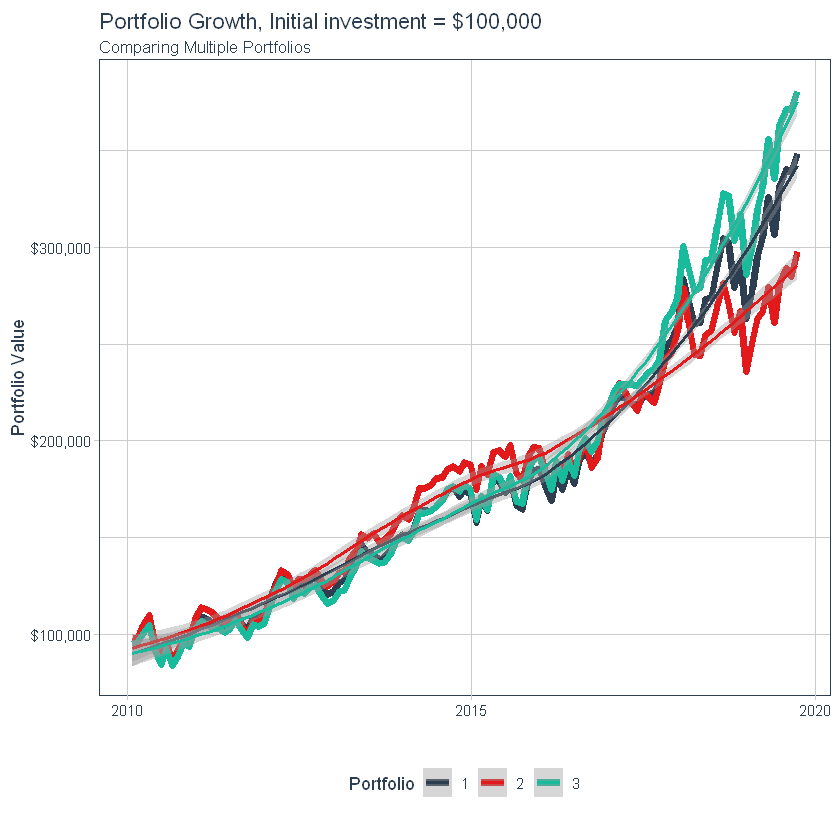

In [25]:
#Multiple Portfolios
weights <- c(
  0.3237408, 0.2539673, 0.4222919, #Optimal
  0.25, 0.50, 0.25,
  0.25, 0.25, 0.50
)
stocks <- c("IBM", "WFC", "MSFT")
weights_table <-  tibble(stocks) %>%
  tq_repeat_df(n = 3) %>%
  bind_cols(tibble(weights)) %>%
  group_by(portfolio)


portfolio_growth_monthly_multi <- stock_returns_monthly_multi %>%
    tq_portfolio(assets_col   = symbol, 
                 returns_col  = Ra, 
                 weights      = weights_table, 
                 col_rename   = "investment.growth",
                 wealth.index = TRUE) %>%
    mutate(investment.growth = investment.growth * pv)

portfolio_growth_monthly_multi %>%
    ggplot(aes(x = date, y = investment.growth, color = factor(portfolio))) +
    geom_line(size = 2) +
    labs(title = "Portfolio Growth, Initial investment = $100,000",
         subtitle = "Comparing Multiple Portfolios",
         caption = "",
         x = "", y = "Portfolio Value",
         color = "Portfolio") +
    geom_smooth(method = "loess") +
    theme_tq() +
    scale_color_tq() +
    scale_y_continuous(labels = scales::dollar)
tail(portfolio_growth_monthly_multi)